# Segmenting and Clustering Neighborhoods in Toronto

Imagine you live in a neighborhood of Toronto and receive a good job proposal on the other side of the city, so you want to move to a new neighborhood closer to the new job but also want to have same facilities around. How could we find this neighborhood similar to the current one you're living in?

In this context, we will explore, segment, and cluster the neighborhoods in the city of Toronto in terms of kinds of venues available on each of them. 
However, Toronto's neighborhood data is not readily available on the internet, but there is a Wikipedia page with all the information we need.

Thus, I will scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe. 
Once the data is in a structured format, I can analyse, explore, using Foursquare API, and cluster the neighborhoods in the city of Toronto.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Scraping data from Wikipedia</a>\
    1.1. <a href="#item11">Reading data from Wikipedia</a>\
    1.2. <a href="#item12">Data wrangling and cleaning</a>

2. <a href="#item2">Adding latitude-longitude coordinates to each neighborhood</a>\
    2.1. <a href="#item21">Retrieve latitude-longitude with Geocoder</a>\
    2.2. <a href="#item22">Getting latitude-longitude from available table</a>

3. <a href="#item3">Explore the neighborhoods in Toronto</a>\
    3.1. <a href="#item31">Create a map of Toronto with neighborhoods</a>\
    3.2. <a href="#item32">Explore the neighborhoods via Foursquare API</a>

4. <a href="#item4">Cluster the neighborhoods</a>\
    4.1. <a href="#item41">Clustering</a>\
    4.2. <a href="#item42">Visualization of clusters</a>

5. <a href="#item5">Discussion</a>

   <a href="#item6">Conclusion</a>
</font>
</div>

<a id='item1'></a>

## 1. Scraping data from Wikipedia

Firstly, using pandas module, we can read available tables within a page.

In [1]:
# Importing necessary modules
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

<a id='item11'></a>

### 1.1. Reading data from Wikipedia
Once we know the page we'd like to scrape data, with the method ```pandas.read_html()``` we can read tables on it.

In [2]:
# Defining the wikipedia URL on varibale wiki_url.
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
# Reading the table on page containing our desired data.
postal_df = pd.read_html(wiki_url)[0]
print(postal_df.shape)
postal_df.head(3)

(180, 3)


,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods


<a id='item12'></a>

### 1.2. Data wrangling and cleaning

Now we have read the table from Wikipedia, we need to clean the undesired and unuseful data from it.

In this case, there are some rows with ```"Not assigned"``` data as _Borough_ and _Neighborhood_ features, which we will drop from the dataframe.
Also, we will drop the _Postal Code_ column, since this data is not usefull for this project.

In [3]:
postal_df['Borough'].replace('Not assigned', np.nan, inplace=True)
postal_df.dropna(inplace=True)
postal_df.reset_index(inplace=True, drop=True)
postal_df.head(3)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
print("The final shape of dataframe is: ", postal_df.shape)

The final shape of dataframe is:  (103, 3)


<a id='item2'></a>

## 2. Adding latitude-longitude coordinates to each neighborhood

Now we have listed all boroughs and neighborhoods in Toronto, let's add their geographical coordinates (latitude-longitude) so we can explore, segment and cluster based on each of their localization.

<a id='item21'></a>

### 2.1. Retrieve latitude-longitude with Geocoder
One way to do that is using the [```geocoder``` module](https://geocoder.readthedocs.io/index.html), an opensource geocoding library writen in Python that, among many functionalities, retrieves the latitude-longitude coordinates given an address/neighborhood.

However, with this Package we have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So we can make a call to get the latitude and longitude coordinates of a given postal code and the result would be **None**, and then make the call again and we would get the coordinates. So, in order to make sure that we get the coordinates for all of our neighborhoods, we can run a while loop for each postal code.

In [ ]:
# Importing geocoder
import geocoder

# Initializing our variable to None
lat_lng_coords = None
latitude = []  # list to store latitudes
longitude = []  # list to store longitudes
counter = 0  # counter to limit attempts

# Loop until we get the coords for each postal code on our dataset
for postal_code in (postal_df['Postal Code']):
    while (lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
        counter += 1
        
        # After trying 50 times, if no coords were retrieved, declare impossible.
        if(counter>50 and lat_lng_coords is None):
            print("Could not retrieve coords from postal code ", postal_code)
            counter = 0
            break
    
    try:
        latitude.append(lat_lng_coords[0])
        longitude.append(lat_lng_coords[1])
    except:
        pass

In this case, for some postal codes it was impossible to retrieve their geographical coordinates.
>Could not retrieve coords from postal code  M3A\
Could not retrieve coords from postal code  M4A\
Could not retrieve coords from postal code  M5A\
Could not retrieve coords from postal code  M6A\
Could not retrieve coords from postal code  M7A\
Could not retrieve coords from postal code  M9A\
Could not retrieve coords from postal code  M1B

<a id='item22'></a>

### 2.2. Getting latitude-longitude from available table
The other way to get the coordinates is through this [dataset](https://cocl.us/Geospatial_data) containing the geographical coordinates of each postal code of Toronto.

In [5]:
# Reading the table with geographical coordinates
coords_df = pd.read_csv('https://cocl.us/Geospatial_data')
coords_df.head(3)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711


Now, we simply merge both dataframes by `Postal Code` values.

In [6]:
# Merge both dataframes into one named neighborhoods_df.
neighborhoods_df = postal_df.merge(coords_df, left_on='Postal Code', right_on='Postal Code')
neighborhoods_df.head(3)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636


<a id='item3'></a>

## 3. Explore the neighborhoods in Toronto

To begin the exploration, let's better understand our new dataset.

In [7]:
print('Toronto has {} Boroughs, and {} Neighborhoods.'.format(len(neighborhoods_df['Borough'].unique()), neighborhoods_df['Neighborhood'].shape[0]))

Toronto has 10 Boroughs, and 103 Neighborhoods.


As we can see, in Toronto there are 10 Boroughs and 103 Neighborhoods!

In [8]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Toronto City are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Toronto City are 43.6534817, -79.3839347.


<a id='item31'></a>

### 3.1. Create a map of Toronto with neighborhoods

To create the neighborhoods' map of Toronto we can use [`Folium` module](https://python-visualization.github.io/folium/). `Folium` enables interactive visualization of data on a [`leaflet` map](https://leafletjs.com/).

In [9]:
import folium # map rendering library

# Create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_df['Latitude'], neighborhoods_df['Longitude'], neighborhoods_df['Borough'], neighborhoods_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<a id='item32'></a>

### 3.2. Explore the neighborhoods via Foursquare API

Next, with help of [Foursquare API](https://foursquare.com/), let's explore and segment the neighborhoods!

After signing up to Foursquare, define the necessary credentials to use the API.

In [10]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [11]:
CLIENT_ID = 'CLIEND_ID' # your Foursquare ID
CLIENT_SECRET = 'CLIENT_SECRET' # your Foursquare Secret
VERSION = '20180605'
ACCESS_TOKEN = 'ACCESS_TOKEN' # my access token! << hiroshi.

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

#### 3.2.1. Explore venues nearby each neighborhood
Since we want to segment the neighborhoods based on similarity of venues nearby each neighborhood, **we have to explore these venues for each neighborhood**.

To automate this process, given a neighborhood, its latitude-longitude coordinates, the radius within which the venues must be explored, and the limit of venues, let's create this `getNearbyVenues()` function.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

So, running the function above on every neighborhoods of Toronto we **obtain a new dataframe `toronto_venues` containing the venues**.

In [13]:
toronto_venues = getNearbyVenues(names=neighborhoods_df['Neighborhood'],
                                 latitudes=neighborhoods_df['Latitude'],
                                 longitudes=neighborhoods_df['Longitude'])

>

Let's take a look at the new dataset!

In [14]:
print('Toronto_venues.shape: ', toronto_venues.shape)
toronto_venues.head(3)

Toronto_venues.shape:  (2125, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Brookbanks Pool,43.751389,-79.332184,Pool
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop


Now, let's print the **distribution of venues on each neighborhoods** for better understanding of this dataframe.

In [15]:
toronto_venues.groupby('Neighborhood').count().head(3)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22


Let's also print out **the number of unique categories** from all the returned venues.

In [16]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 267 uniques categories.


#### 3.2.2. Analyze each Neighborhood

Since categorical variable cannot be processed in some algorithms, like clustering algorithms we will use soon, we must **transform each category into a binary variable**. One method does that is [**One-hot-enconding**](https://en.wikipedia.org/wiki/One-hot).

In [17]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print('toronto_onehot.shape: ', toronto_onehot.shape)
#toronto_onehot.head()

toronto_onehot.shape:  (2125, 267)


Now, let's **build a profile of each neighborhood in terms of frequency of occurence of each category**. For this, we will group the `toronto_onehot`'s rows by neighborhood and taking the mean of the frequency of occurence of each category.

In [18]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print('toronto_grouped.shape: ', toronto_grouped.shape)
toronto_grouped.head(3)

toronto_grouped.shape:  (95, 267)


,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

>P.S.: note that now we have just 95 neighborhoods on our dataframe, although in the begining we had 103 neighborhoods. This happened at the process of retrieving venues for each neighborhood, i.e., probably for 8 neighborhoods there were no venues!

From the neighborhood profile dataframe `toronto_grouped`, let's considerate only the most common venues on each of the neighborhood. For instance, **let's considerate the first 10 most common venues on each neighborhood**.

In [19]:
# Function to sort the first 'num_top_venues' most common venues on a row.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10  # considerate the first 10 most common venues.
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

print("neighborhoods_venues_sorted.shape: ", neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head(3)

neighborhoods_venues_sorted.shape:  (95, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Skating Rink,Sandwich Place,Pub,Dim Sum Restaurant,Dance Studio,Deli / Bodega,Department Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Park,Frozen Yogurt Shop,Supermarket,Sushi Restaurant,Middle Eastern Restaurant,Shopping Mall,Mobile Phone Shop,Restaurant


<a id='item4'></a>

## 4. Cluster the neighborhoods

Now we have a dataframe containig most relevant data, **let's cluster the neighborhoods using [K-Means method](https://en.wikipedia.org/wiki/K-means_clustering)**.

<a id='item41'></a>

### 4.1. Clustering

For this step we will use the [`Sklearn` module](https://scikit-learn.org/stable/).

In [20]:
# Import K-Means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run K-Means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Now, let's create a new dataframe including the cluster and the top 10 venues for each neighborhood.

In [21]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# copy neighborhoods_df on toronto_merged
toronto_merged = neighborhoods_df

# merge toronto neighborhoods dataframe with neighborhoods profile dataframe
#toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged = toronto_merged.merge(neighborhoods_venues_sorted.set_index('Neighborhood'), left_on='Neighborhood', right_on='Neighborhood')

print("shape of toronto_merged: ", toronto_merged.shape)
toronto_merged.head(3) # check first rows

shape of toronto_merged:  (99, 16)


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4,Park,Food & Drink Shop,Pool,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Portuguese Restaurant,Hockey Arena,Coffee Shop,Intersection,French Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Breakfast Spot,Café,Pub,Theater,Ice Cream Shop,Performing Arts Venue,Shoe Store


<a id='item42'></a>

### 4.2. Visualization of clusters

Finally, let's **visualize the resulting clusters**!

In [22]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Discussion

The result obtained, at least visually, was very heterogeneous in terms of distribution of each cluster. Thinking intuitivelly, this may have happened because there are a lot of similar venues distributed throughout Toronto, so there are plenty of similar neighborhoods.

But still, there are some few different neighborhoods that stands out among others. So, **let's try to see how different they are by plotting some Venn Diagrams**.

In [23]:
# split clusters from toronto_merged dataframe
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, 
                   toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, 
                   toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, 
                   toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, 
                   toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, 
                   toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

# list all unique venues in each cluster
cluster1_venues = np.unique(cluster1.iloc[:, 2:].values)
cluster2_venues = np.unique(cluster2.iloc[:, 2:].values)
cluster3_venues = np.unique(cluster3.iloc[:, 2:].values)
cluster4_venues = np.unique(cluster4.iloc[:, 2:].values)
cluster5_venues = np.unique(cluster5.iloc[:, 2:].values)

In [24]:
#Import libraries for venn plotting
#! pip install matplotlib-venn
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

Since we can plot at most 5 sets on Venn Diagram from matplotlib, we will analyze by 3 clusters in each step.

**Cluster1 x Cluster2 x Cluster3**

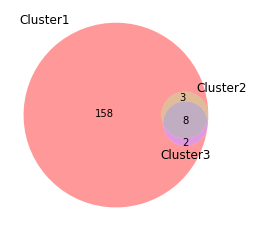

In [25]:
venn3([set(cluster1_venues), set(cluster2_venues), set(cluster3_venues)],
      set_labels=('Cluster1', 'Cluster2', 'Cluster3'))
plt.show()

**Cluster2 x Cluster3 x Cluster4**

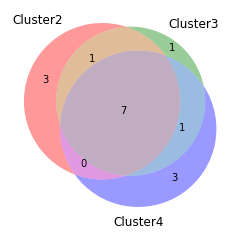

In [26]:
venn3([set(cluster2_venues), set(cluster3_venues), set(cluster4_venues)],
      set_labels=('Cluster2', 'Cluster3', 'Cluster4'))
plt.show()

**Cluster3 x Cluster4 x Cluster5**

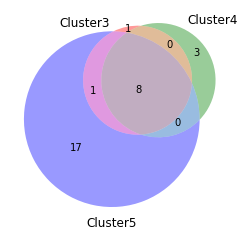

In [27]:
venn3([set(cluster3_venues), set(cluster4_venues), set(cluster5_venues)],
      set_labels=('Cluster3', 'Cluster4', 'Cluster5'))
plt.show()

**Cluster1 x Cluster4 x Cluster5**

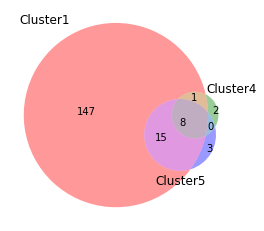

In [28]:
venn3([set(cluster1_venues), set(cluster4_venues), set(cluster5_venues)],
      set_labels=('Cluster1', 'Cluster4', 'Cluster5'))
plt.show()

As expected, the **Cluster1 has much more common venues** in comparison to the other 4 clusters!

And the **Cluster5 has more common venues than clusters 2, 3 and 4**, as can be expected from the visualization on map too; observe that Cluster5 has more points (orange circles) distributed on map than the other 3 smaller clusters.

<a id='item6'></a>

## Conclusion

From this exploration, we can conclude Toronto seems to be a very convenient city to live in terms of easy access to different kinds of venues.

Although we have not explored qualitatively the listed venues, which could be a more deep and detailed exploration we could do if we wanted to cluster the neighborhoods in terms of quality of venues too.